# Compile unitaries with parametrized circuits

> A short tutorial showing unitary compilation with parametrized circuits.

In [ ]:
from genQC.imports import *
import genQC.utils.misc_utils as util

from genQC.dataset.config_dataset import ConfigDataset
from genQC.pipeline.multimodal_diffusion_pipeline import MultimodalDiffusionPipeline_ParametrizedCompilation
from genQC.scheduler.scheduler_dpm import DPMScheduler

from genQC.platform.tokenizer.circuits_tokenizer import CircuitTokenizer
from genQC.platform.simulation import Simulator, CircuitBackendType
from genQC.inference.sampling import decode_tensors_to_backend, generate_compilation_tensors
from genQC.inference.evaluation_helper import get_unitaries
from genQC.inference.eval_metrics import UnitaryInfidelityNorm
from genQC.dataset.balancing import get_tensor_gate_length

In [ ]:
util.MemoryCleaner.purge_mem()      # clean existing memory alloc
device = util.infer_torch_device()  # use cuda if we can
device

[INFO]: Cuda device has a capability of 8.6 (>= 8), allowing tf32 matmul.


device(type='cuda')

In [ ]:
# We set a seed to pytorch, numpy and python. 
# Note: This will also set deterministic algorithms, possibly at the cost of reduced performance!
util.set_seed(0)

## Load model

Load the pre-trained model directly from [Hugging Face: Floki00/cirdit_multimodal_compile_3to5qubit](https://huggingface.co/Floki00/cirdit_multimodal_compile_3to5qubit).

In [ ]:
pipeline = MultimodalDiffusionPipeline_ParametrizedCompilation.from_pretrained("Floki00/cirdit_multimodal_compile_3to5qubit", device)

The model is trained with the gate set:

In [ ]:
pipeline.gate_pool

['h', 'cx', 'ccx', 'swap', 'rx', 'ry', 'rz', 'cp']

which we need in order to define the `vocabulary`, allowing us to decode tokenized circuits.

In [ ]:
vocabulary = {g:i+1 for i, g in enumerate(pipeline.gate_pool)} 
tokenizer  = CircuitTokenizer(vocabulary)
tokenizer.vocabulary

{'h': 1, 'cx': 2, 'ccx': 3, 'swap': 4, 'rx': 5, 'ry': 6, 'rz': 7, 'cp': 8}

### Set inference parameters

Set diffusion model inference parameters.

In [ ]:
pipeline.scheduler   = DPMScheduler.from_scheduler(pipeline.scheduler)
pipeline.scheduler_w = DPMScheduler.from_scheduler(pipeline.scheduler_w)

timesteps = 40
pipeline.scheduler.set_timesteps(timesteps) 
pipeline.scheduler_w.set_timesteps(timesteps) 

pipeline.lambda_h = 1.0
pipeline.lambda_w = 0.35
pipeline.g_h = 0.3
pipeline.g_w = 0.1

We assume in this tutorial circuits of 4 qubits.

In [ ]:
num_of_samples_per_U = 32  # How many circuits we sample per unitary
num_of_qubits = 4

prompt = "Compile 4 qubits using: ['h', 'cx', 'ccx', 'swap', 'rx', 'ry', 'rz', 'cp']"

# These parameters are specific to our pre-trained model.
system_size   = 5
max_gates     = 32

For evaluation, we also need a circuit simulator backend.

In [ ]:
simulator = Simulator(CircuitBackendType.QISKIT)

## Load test unitaries

We load a balanced testset directly from [Hugging Face: Floki00/unitary_compilation_testset_3to5qubit](https://huggingface.co/datasets/Floki00/unitary_compilation_testset_3to5qubit).

In [ ]:
testset = ConfigDataset.from_huggingface("Floki00/unitary_compilation_testset_3to5qubit", device="cpu")

We pick the 4 qubit circuits as test cases for this tutorial.

In [ ]:
target_xs = testset.xs_4qubits  # tokenized circuit
target_ps = testset.ps_4qubits  # circuit angle paramters
target_us = testset.us_4qubits.float()  # corresponding unitaries, 

For 4 qubits the unitary is a 16x16 matrix. Complex numbers are split into 2 channels (real, imag).

In [ ]:
target_us.shape  # [batch, 2, 2^n, 2^n]

torch.Size([3947, 2, 16, 16])

A random circuit may look like this:

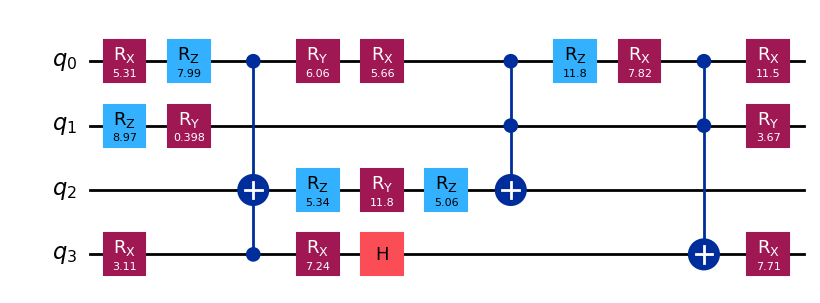

In [ ]:
rnd_index = torch.randint(target_us.shape[0], (1, ))

qc_list, _ = decode_tensors_to_backend(simulator, tokenizer, target_xs[rnd_index], target_ps[rnd_index])
qc_list[0].draw("mpl")

Next, we further restrict to circuits with a maximum of 16 gates. 

In [ ]:
gate_cnts = get_tensor_gate_length(target_xs)

ind = (gate_cnts <= 16).nonzero().squeeze()
target_xs = target_xs[ind] 
target_ps = target_ps[ind]  
target_us = target_us[ind] 

We plot the distribution of the gate counts for this testset, seeing it is uniformly balanced.

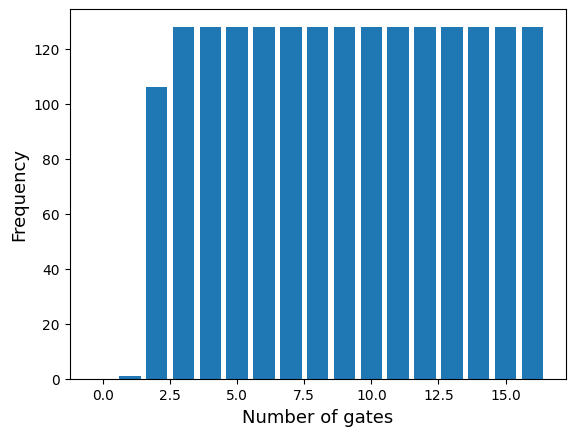

In [ ]:
gate_cnts = get_tensor_gate_length(target_xs)

d = np.bincount(gate_cnts)
plt.bar(range(d.size), d)
plt.xlabel("Number of gates", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.show()

## Compile a single unitary

First, we want to compile a single unitary for 4 qubits from the testset. We pick one with 8 gates.

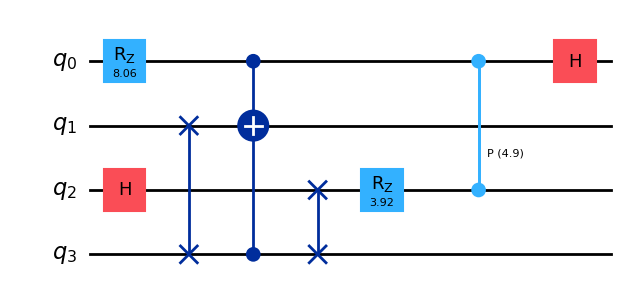

In [ ]:
ind = (gate_cnts == 8).nonzero().squeeze()[:1]

qc_list, _ = decode_tensors_to_backend(simulator, tokenizer, target_xs[ind], target_ps[ind])
qc_list[0].draw("mpl")

In [ ]:
U = target_us[ind].squeeze()

out_tensor, params = generate_compilation_tensors(pipeline, 
                                                  prompt=prompt, 
                                                  U=U, 
                                                  samples=num_of_samples_per_U, 
                                                  system_size=system_size, 
                                                  num_of_qubits=num_of_qubits, 
                                                  max_gates=max_gates,
                                                  no_bar=False,  # show progress bar
                                                 )

  0%|          | 0/40 [00:00<?, ?it/s]

[INFO]: (generate_comp_tensors) Generated 32 tensors


For instance, a circuit tensor alongside parameters the model generated looks like this

In [ ]:
print(out_tensor[0])
print(params[0])

tensor([[ 7,  8,  0, -3,  1,  0,  0,  0,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9],
        [ 0,  8,  0, -3,  0,  7,  4,  0,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9],
        [ 0,  0,  4,  3,  0,  0,  4,  0,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9],
        [ 0,  0,  4,  0,  0,  0,  0,  1,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9]], device='cuda:0')
tensor([[ 0.2794,  0.1956,  0.0000,  0.0000,  0.0000, -0.3857,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')


### Evaluate and plot circuits

We decode these now to circuits and calculate their unitaries

In [ ]:
generated_qc_list, _ = decode_tensors_to_backend(simulator, tokenizer, out_tensor, params)
generated_us         = get_unitaries(simulator, generated_qc_list)

We then evaluate the unitary infidelity to our target `U`.

In [ ]:
U_norms = UnitaryInfidelityNorm.distance(
                    approx_U=torch.from_numpy(np.stack(generated_us)).to(torch.complex128), 
                    target_U=torch.complex(U[0], U[1]).unsqueeze(0).to(torch.complex128),
                )

We plot the four best ciruits, w.r.t. the infidelity:

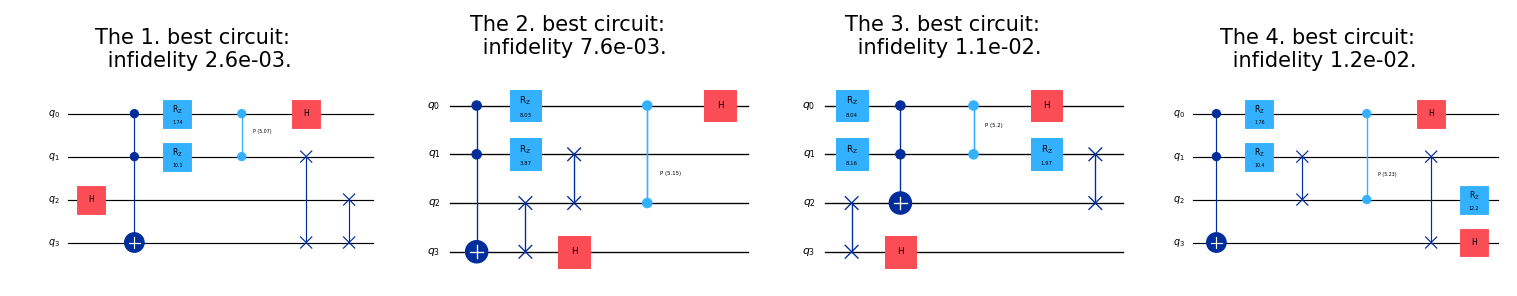

In [ ]:
plot_k_best = 4

idx = np.argsort(U_norms)
fig, axs = plt.subplots(1, plot_k_best, figsize=(10, 2), constrained_layout=True, dpi=150)

for i, (idx_i, ax) in enumerate(zip(idx[:plot_k_best], axs.flatten())): 
    ax.clear()
    generated_qc_list[idx_i].draw("mpl", plot_barriers=False, ax=ax)
    ax.set_title(f"The {i+1}. best circuit: \n infidelity {U_norms[idx_i]:0.1e}.", fontsize=10)

## Compile testset unitaries

To get an overall performance estimation, we compile multiple unitaries, record the best infidelities and plot the distribution.

### Generate tensors

To keep the tutorial short in computation time, we only take a few unitaries here, but this can be adjusted by the user to use the full testset.

In [ ]:
Us = target_us[:16]

In [ ]:
best_infidelities = []

for U in tqdm(Us):
    out_tensor, params = generate_compilation_tensors(pipeline, 
                                                      prompt=prompt, 
                                                      U=U, 
                                                      samples=num_of_samples_per_U, 
                                                      system_size=system_size, 
                                                      num_of_qubits=num_of_qubits, 
                                                      max_gates=max_gates
                                                     )

    generated_qc_list, _ = decode_tensors_to_backend(simulator, tokenizer, out_tensor, params)
    generated_us         = get_unitaries(simulator, generated_qc_list)

    U_norms = UnitaryInfidelityNorm.distance(
                    approx_U=torch.from_numpy(np.stack(generated_us)).to(torch.complex128), 
                    target_U=torch.complex(U[0], U[1]).unsqueeze(0).to(torch.complex128),
                )

    best_infidelities.append(U_norms.min())

  0%|          | 0/16 [00:00<?, ?it/s]

### Plot infidelities

For the compiled unitaries, we get the following distribution of the best infidelities.

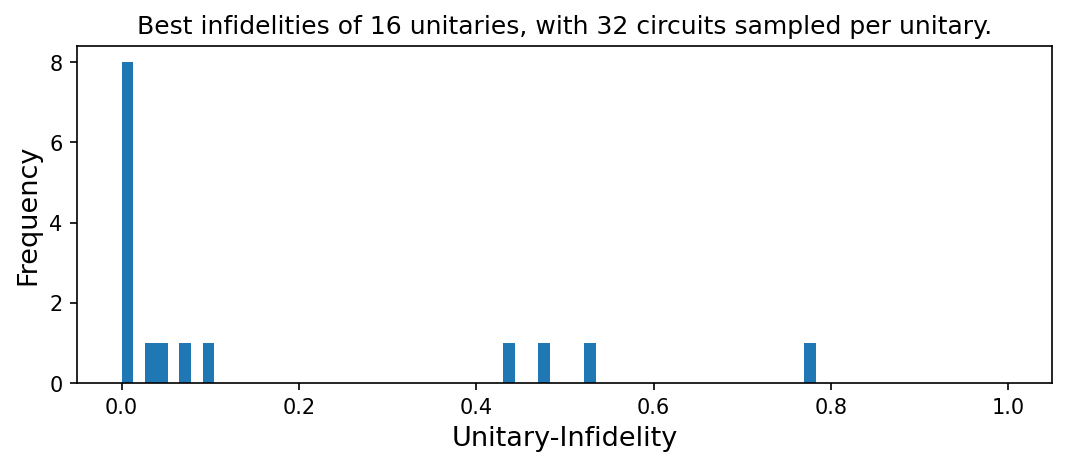

In [ ]:
plt.figure(figsize=(7, 3), constrained_layout=True, dpi=150)
plt.title(f"Best infidelities of {len(best_infidelities)} unitaries, with {num_of_samples_per_U} circuits sampled per unitary.")
plt.xlabel(UnitaryInfidelityNorm.name(), fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.hist(best_infidelities, bins=60)
plt.xlim([-0.05, 1.05])
plt.show()

In [ ]:
import genQC
print("genQC Version", genQC.__version__)

genQC Version 0.2.0
